In [1]:
import pickle
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import fuzzywuzzy
from fuzzywuzzy import process

import warnings
warnings.filterwarnings('ignore')

import clean

/home/kieran/Downloads/Software/miniconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [5]:
with open("./data/file_list", "rb") as fp:
    b = pickle.load(fp)
surveys = [x for x in b if 'Metadata' not in x]

site_name = 'saltfl'
site_files = []
for file_name in surveys:
    if site_name.lower() in file_name.lower():
        site_files.append(file_name)

for ss in site_files:
    print(ss)

data/Saltfleetby_/Long_term_monitoring_network_vegetation_survey_Saltfleetby-Theddlethorpe_Dunes_NNR_2017.xlsx
data/Saltfleetby_/Long_term_monitoring_network_vegetation_survey_Saltfleetby-Theddlethorpe_Dunes_NNR_2013.xlsx


In [8]:
data = []
for site in site_files:
    xls = pd.ExcelFile(site)

    for name in xls.sheet_names:
        if 'whole' in name.lower():
            wpd_string = name
        if 'species te' in name.lower():
            spec_temp_string = name
        if 'ground' in name.lower():
            ground_string = name

    whole = xls.parse(wpd_string)
    whole = clean.whole_clean(whole)

    species = xls.parse(spec_temp_string)
    species = clean.species_clean(species)
    cover, frequency = clean.get_abund_and_freq(species, column='desc_latin')

    ground = xls.parse(ground_string)
    ground = clean.ground_clean(ground)


    ####################################################################
    # extracting the useful information
    ####################################################################

    df = pd.DataFrame()

    year = whole['year'][0].astype(str)

    df['year'] = whole['year']
    df['bap_b'] = whole['bap_broad']
    df['bap_p'] = whole['bap_priority']
    df['freq_count'] = frequency.gt(0).sum(axis=1)
    df['max_height'] = ground['max_height']
    df['median_height'] = ground['median_height']
    df['freq-bare soil'] = ground['freq-bare soil']
    data.append(df)

print('whole\n')
print(whole.head())
print('\ncover\n')
print(cover.head())
print('\nground\n')
print(ground.head())

whole
           sitecode mcode  year plot_id    eastings   northings  altitude  \
index_id                                                                    
1_B39_2013      B39    VC  2013       1  546009.290  393356.640       1.5   
2_B39_2013      B39    VC  2013       2  546040.003  393270.335       3.0   
3_B39_2013      B39    VC  2013       3  546092.109  393192.301       2.0   
4_B39_2013      B39    VC  2013       4  546189.003  393101.835       3.0   
5_B39_2013      B39    VC  2013       5  546322.585  393369.497       1.0   

            landuse_code  slope  aspect  slopeform_code  scode1  scode2  \
index_id                                                                  
1_B39_2013          17.0    4.0    45.0             2.0     NaN     NaN   
2_B39_2013          17.0    4.0     3.0             2.0     NaN     NaN   
3_B39_2013          17.0    6.0     3.0             2.0     NaN     NaN   
4_B39_2013          17.0    0.0     0.0             2.0     NaN     NaN   
5_B3

In [11]:
n_sites = len(data)
data2 = data[::-1]
total_data = pd.concat(data2)

print('number of surveys - ', n_sites, '\n')
print(total_data.head())

number of surveys -  2
            year              bap_b              bap_p  freq_count  \
index_id                                                             
1_B39_2013  2013  Littoral sediment  Coastal saltmarsh         3.0   
2_B39_2013  2013  Littoral sediment  Coastal saltmarsh         3.0   
3_B39_2013  2013  Littoral sediment  Coastal saltmarsh         2.0   
4_B39_2013  2013  Littoral sediment  Coastal saltmarsh         2.0   
5_B39_2013  2013  Littoral sediment  Coastal saltmarsh         3.0   

            max_height  median_height  freq-bare soil  
index_id                                               
1_B39_2013        22.5           17.5            15.0  
2_B39_2013        33.0           19.0            11.0  
3_B39_2013        29.0           18.0            14.0  
4_B39_2013        35.0           31.0            13.0  
5_B39_2013        41.5           23.0             0.0  


In [12]:
def check_names(list_of_names, min_ratio = 90):

    print('\nchecking for typos\n')
    for pp in list_of_names:
        matches = fuzzywuzzy.process.extract(pp, list_of_names, limit=2, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
        if matches[1][1] > min_ratio:
            print(pp, ' - ', matches)

def replace_matches_in_column(df, column, string_to_match, min_ratio = 90):
    # get a list of unique strings
    strings = df[column].unique()

    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings,
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches
    df.loc[rows_with_matches, column] = string_to_match

    
total_data = total_data[total_data['bap_b'].notna()]
total_data['bap_b'] = total_data['bap_b'].str.lower()

names = total_data['bap_b'].unique()
print('list of unique names in bap_b\n')
print(names)
names = [x for x in names if str(x) != 'nan']
check_names(names, min_ratio = 80)

replace_matches_in_column(total_data, 'bap_b', 'fen, marsh and swamp', min_ratio = 80)
replace_matches_in_column(total_data, 'bap_b', 'supralittoral sediment')

bap_b = total_data['bap_b'].unique()
fig_num = len(bap_b)

['littoral sediment' 'supralittoral sediment' 'fen, marsh and swamp'
 'calcareous grassland' 'supralitoral sediment' 'fen marsh or swamp']

checking for typos

supralittoral sediment  -  [('supralittoral sediment', 100), ('supralitoral sediment', 98)]
fen, marsh and swamp  -  [('fen, marsh and swamp', 100), ('fen marsh or swamp', 81)]
supralitoral sediment  -  [('supralitoral sediment', 100), ('supralittoral sediment', 98)]
fen marsh or swamp  -  [('fen marsh or swamp', 100), ('fen, marsh and swamp', 81)]


__supralitoral sediment__ is converted to __supralittoral sediment__ and __fen marsh or swamp__ is converted to __fen, marsh and swamp__

In [30]:
years = total_data['year'].unique()
for yy in years:
    df = total_data[total_data['year'] == yy]
    print('\n', yy, '\n')
    print(df['bap_b'].value_counts())


 2013 

littoral sediment         20
supralittoral sediment    18
fen, marsh and swamp      10
calcareous grassland       7
Name: bap_b, dtype: int64

 2017 

littoral sediment         23
supralittoral sediment    23
fen, marsh and swamp       2
calcareous grassland       1
Name: bap_b, dtype: int64


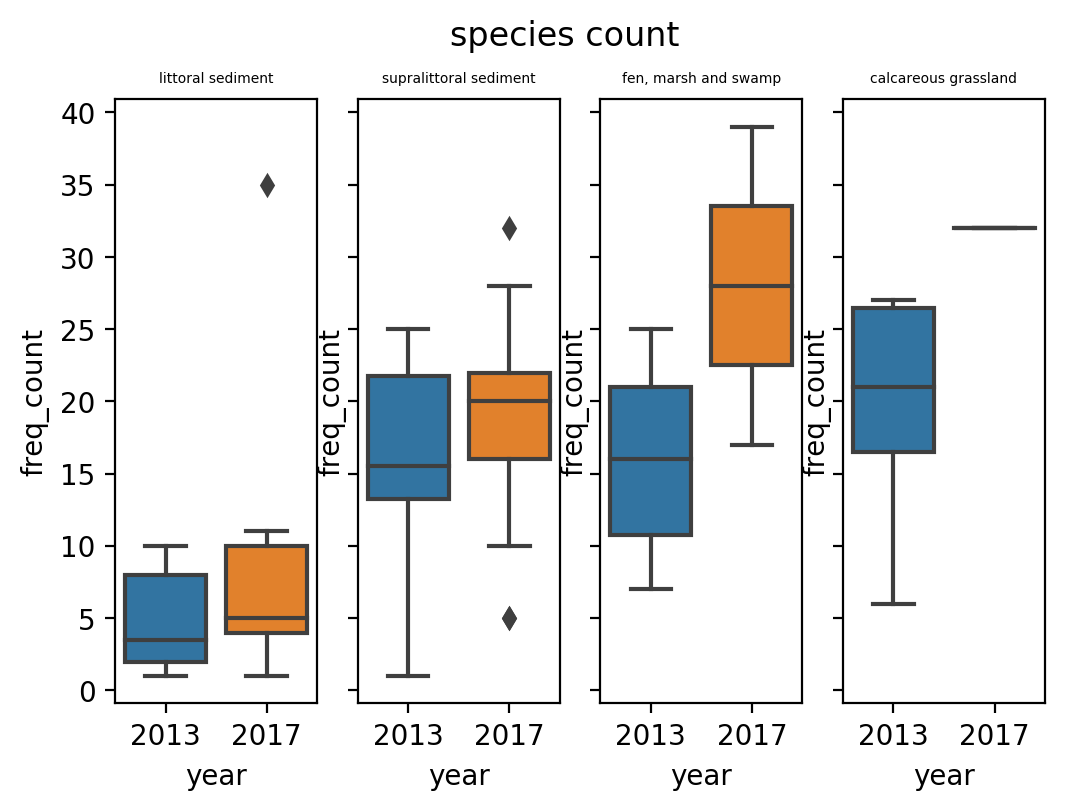

In [31]:
fig, axes = plt.subplots(ncols=fig_num, sharey=True, dpi=200)
fig.suptitle('species count')
for i, ax in zip(range(10), axes.flat):
    sns.boxplot(data = total_data[total_data['bap_b'] == bap_b[i]],
        x='year', y='freq_count', ax=ax).set_title(bap_b[i], fontsize=6)
plt.show()

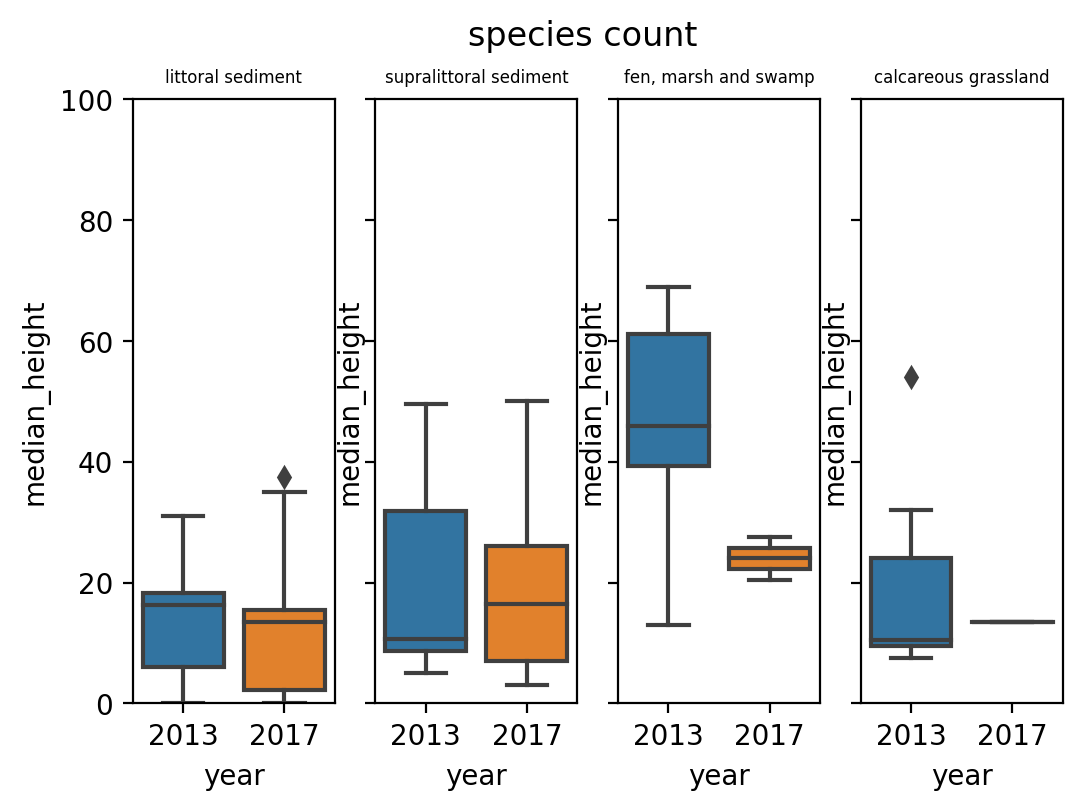

In [34]:
fig, axes = plt.subplots(ncols=fig_num, sharey=True, dpi=200)
fig.suptitle('species count')
for i, ax in zip(range(10), axes.flat):
    sns.boxplot(data = total_data[total_data['bap_b'] == bap_b[i]],
        x='year', y='median_height', ax=ax).set_title(bap_b[i], fontsize=6)
    ax.set(ylim=(0, 100))
plt.show()